# Minh Tuan Lam - Vision AI intern assignment - Cat and Dog classification

Link of the used dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Use multiple GPUs
strategy = tf.distribute.MirroredStrategy()
print(f'We are using {strategy.num_replicas_in_sync} GPUs!')

We are using 2 GPUs!


In [3]:
# Define some constants
img_height = 224
img_width = 224

## Data preprocessing

First, we need to read the images and apply some data augmentation.

In [26]:
train_gen = ImageDataGenerator(
    # Normalize images
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=0.1,
    zoom_range=0.1,
    validation_split=0.1,
)
test_gen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator=train_gen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator=train_gen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
test_generator=test_gen.flow_from_directory(
    '/kaggle/input/cat-and-dog/test_set/test_set',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 7205 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


Visualize some images in the train set.

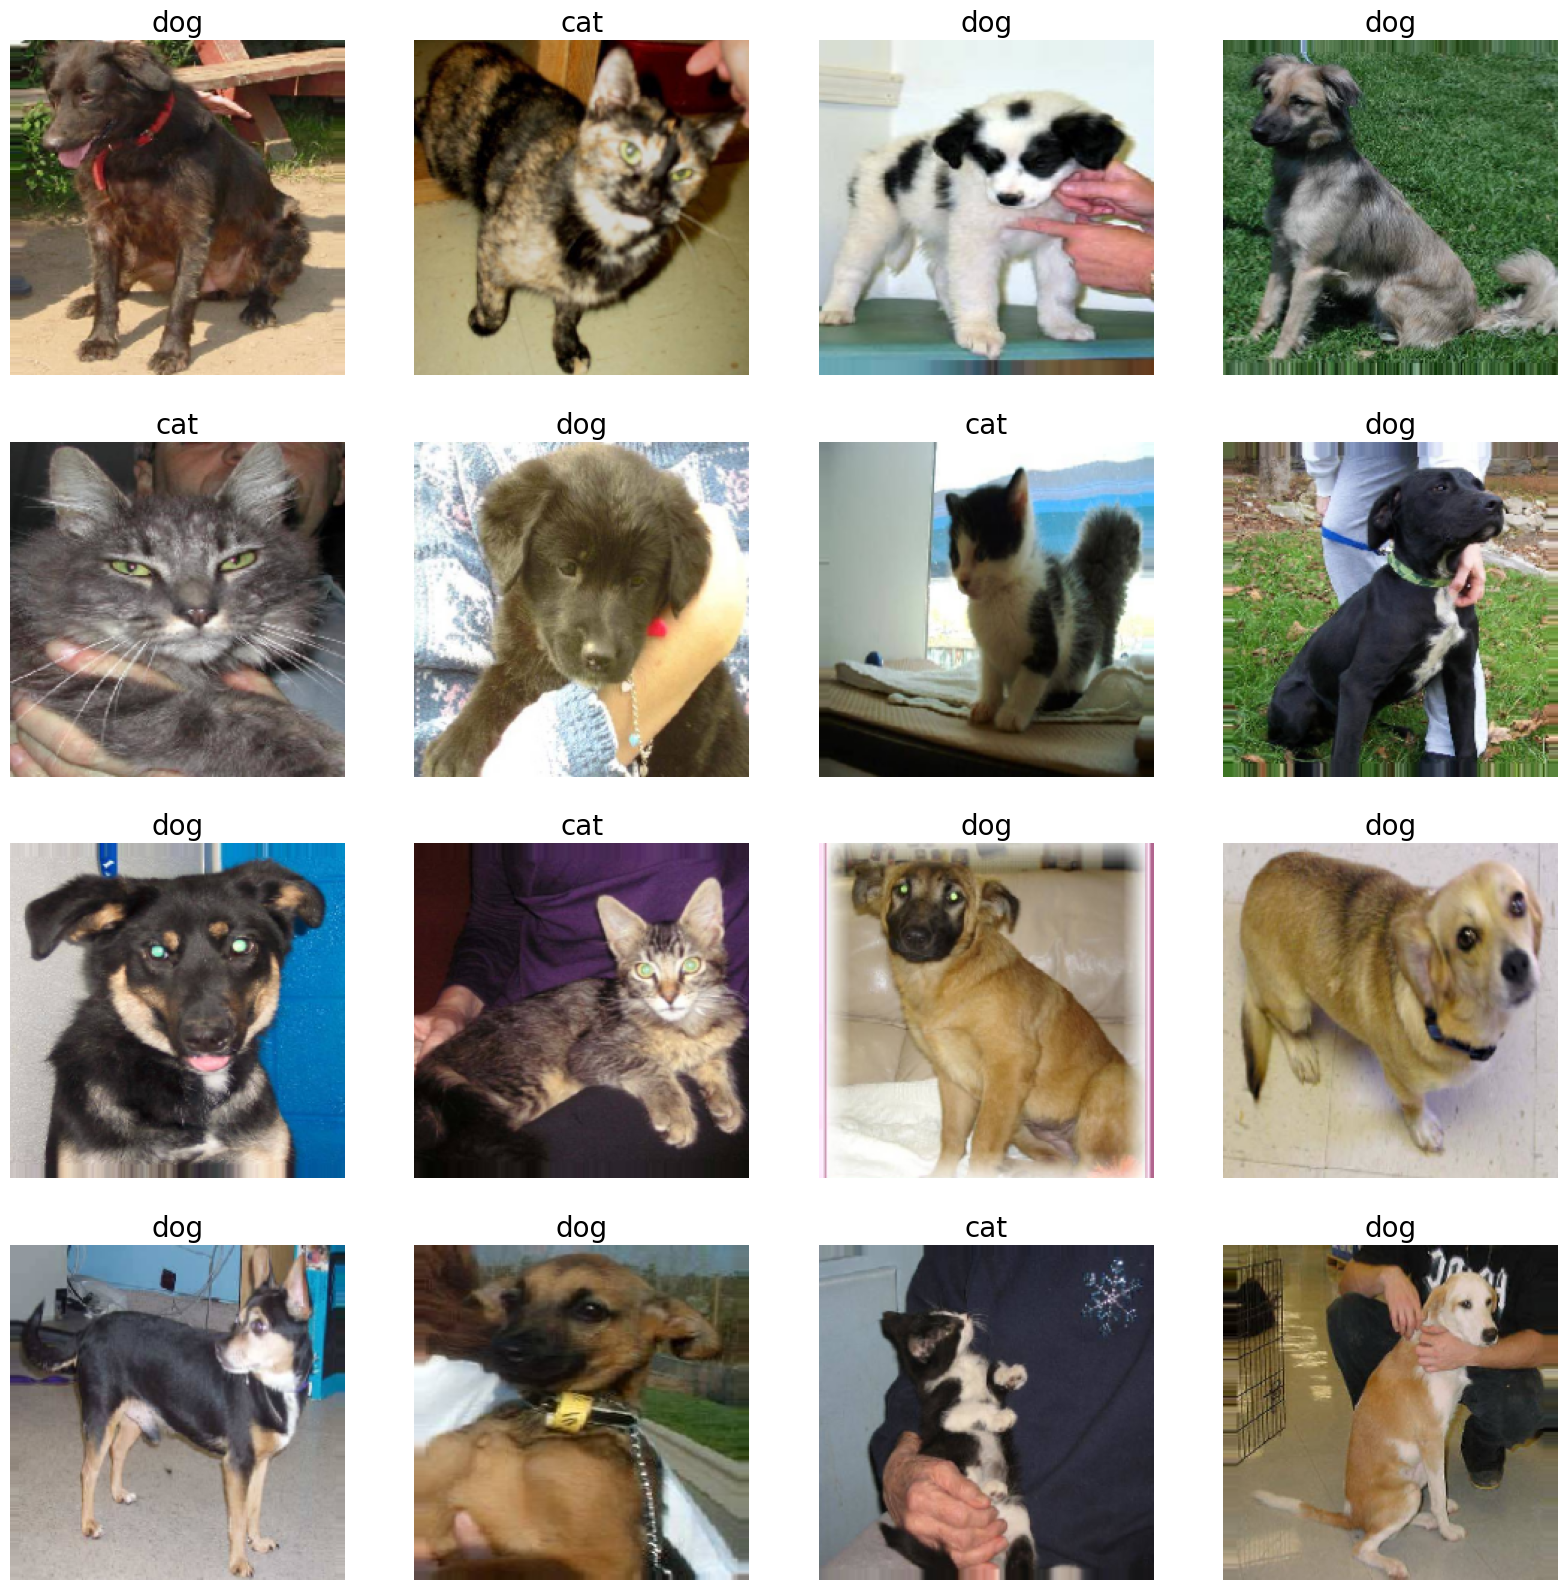

In [28]:

images, labels = train_generator.next()
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(16):
    lb = 'cat' if labels[i] == 0 else 'dog'
    axs[i // 4, i % 4].imshow(images[i])
    axs[i // 4, i % 4].set_title(lb, fontsize=20)
    axs[i // 4, i % 4].axis('off')

# Model

We can use the technique called "transfer learning" and "fine-tuning" to take advantage of state-of-the-art models and save time. But in this assignment, I will build the model from scratch.

In [29]:
def build_model():
    model = Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPool2D((2, 2), 2),
        
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPool2D((2, 2), 2),

#         layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         layers.MaxPool2D((2, 2), 2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(16, activation='relu'),
        layers.Dense(2, activation='sigmoid')
    ])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model


In [30]:
with strategy.scope():

    model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [31]:
# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [32]:
model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[callback],)

Epoch 1/100
226/226 [==============================] - 120s 500ms/step - loss: 0.6936 - accuracy: 0.5051 - val_loss: 0.6928 - val_accuracy: 0.5013
Epoch 2/100
226/226 [==============================] - 112s 494ms/step - loss: 0.6938 - accuracy: 0.5058 - val_loss: 0.6929 - val_accuracy: 0.5050
Epoch 3/100
226/226 [==============================] - 113s 499ms/step - loss: 0.6893 - accuracy: 0.5413 - val_loss: 0.6834 - val_accuracy: 0.5550
Epoch 4/100
226/226 [==============================] - 113s 498ms/step - loss: 0.6808 - accuracy: 0.5566 - val_loss: 0.6549 - val_accuracy: 0.5863
Epoch 5/100
226/226 [==============================] - 114s 505ms/step - loss: 0.6853 - accuracy: 0.5535 - val_loss: 0.6743 - val_accuracy: 0.5700
Epoch 6/100
226/226 [==============================] - 113s 502ms/step - loss: 0.6689 - accuracy: 0.5745 - val_loss: 0.6463 - val_accuracy: 0.5713
Epoch 7/100
226/226 [==============================] - 113s 502ms/step - loss: 0.6633 - accuracy: 0.5853 - val_loss: 0

In [33]:
model.save('/kaggle/working/classifier')

## Evaluate model

In [34]:
model.evaluate(test_generator)

64/64 [==============================] - 23s 360ms/step - loss: 0.3453 - accuracy: 0.8581


[0.34533703327178955, 0.858131468296051]

We achieve accuracy near 90%!

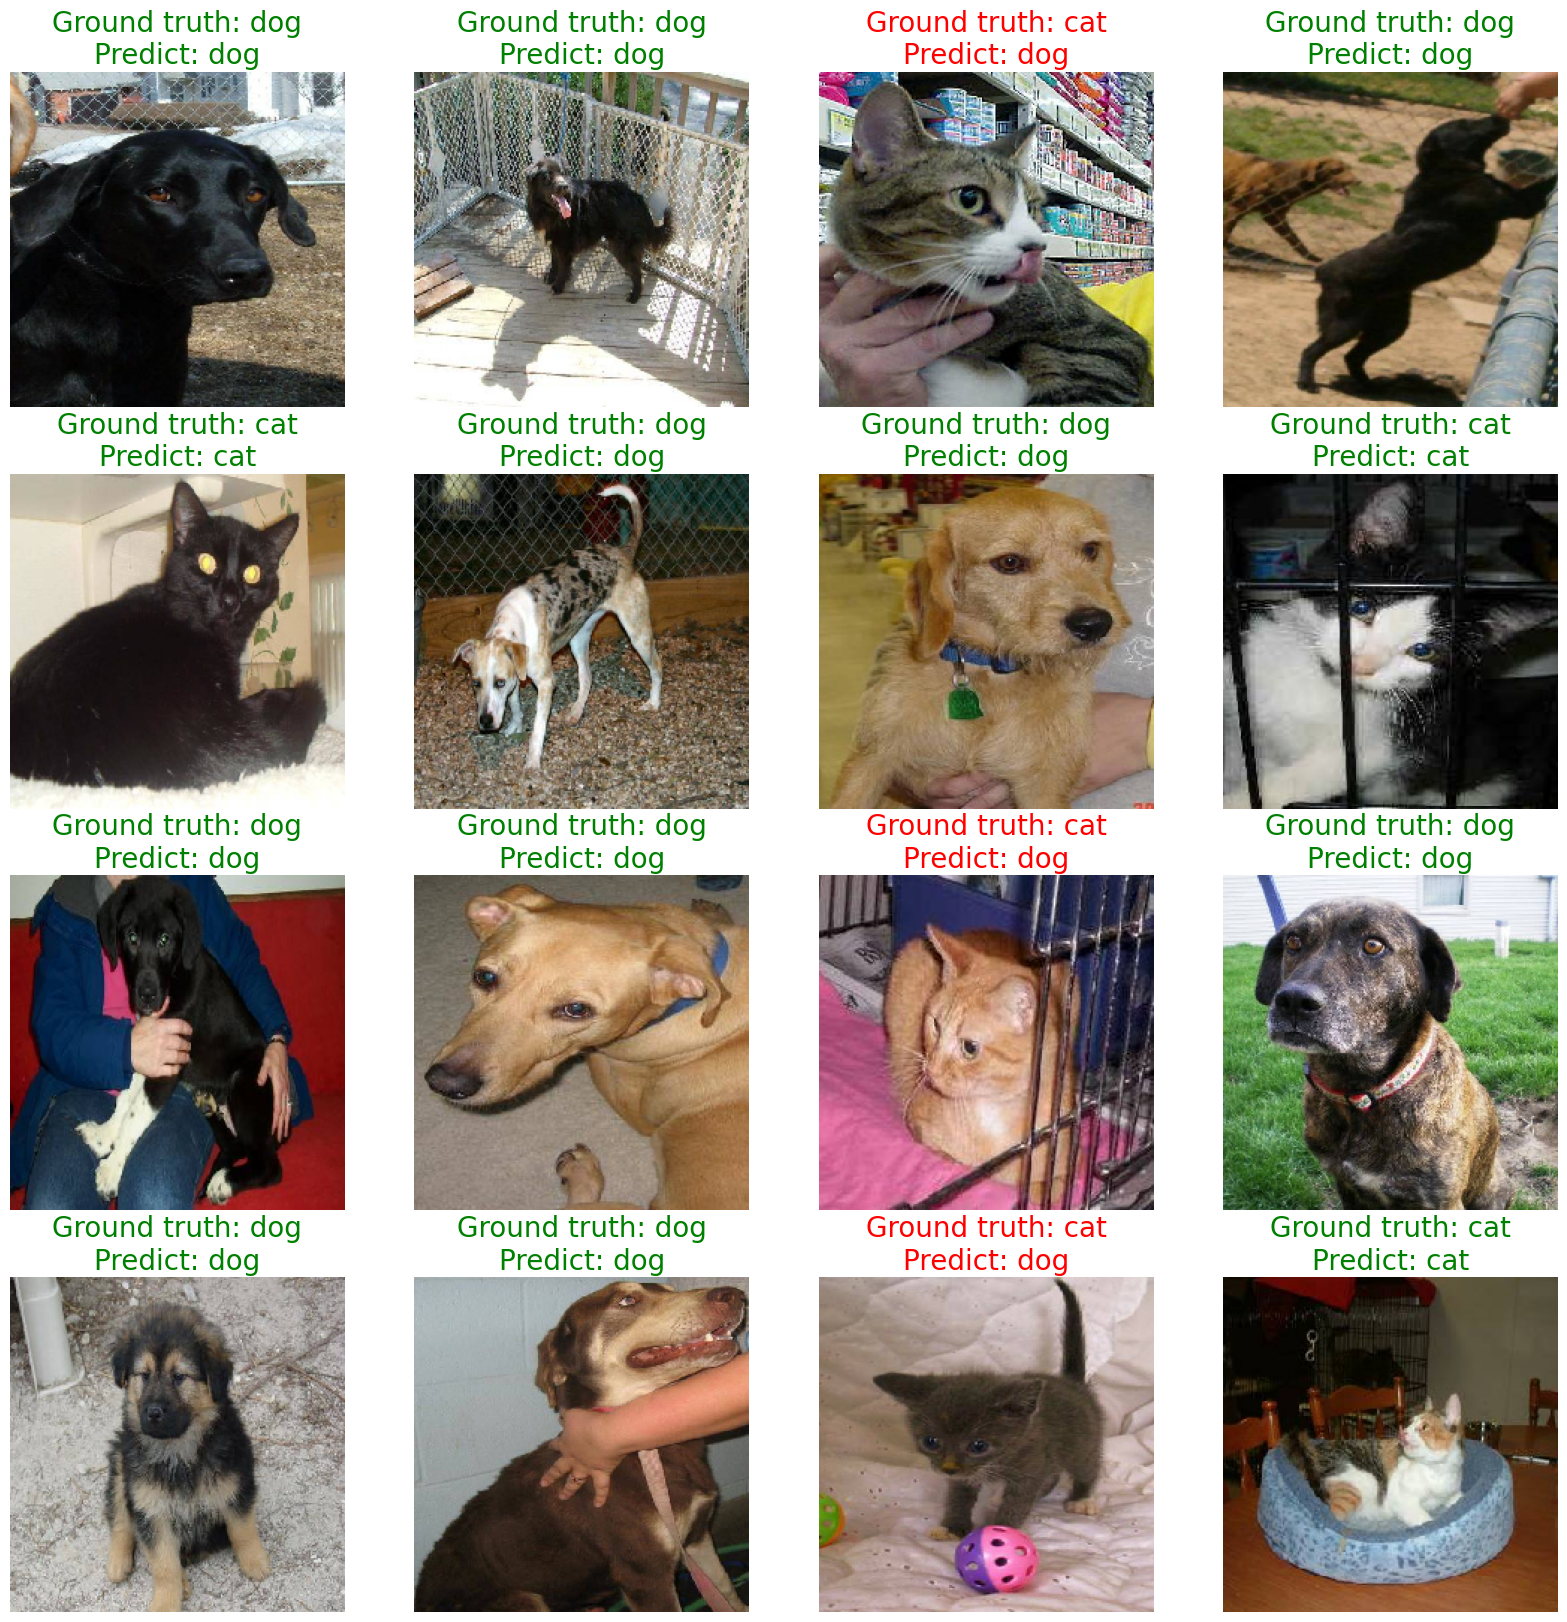

In [37]:
y_true = []
y_pred = []
plot = True
for i in range(len(test_generator)):
    images, labels = test_generator.next()
    y_true.extend(labels)
    prob = model.predict(images, verbose=0) 
    pred_class = np.argmax(prob, axis=1)
    y_pred.extend(pred_class)
    if plot:
        fig, axs = plt.subplots(4, 4, figsize=(20, 20))
        for j in range(16):
            pred_lb = 'cat' if pred_class[j] == 0 else 'dog'
            truth_lb = 'cat' if labels[j] == 0 else 'dog'
            color = 'green' if pred_lb == truth_lb else 'red'
            axs[j // 4, j % 4].imshow(images[j])
            axs[j // 4, j % 4].set_title(f'Ground truth: {truth_lb}\nPredict: {pred_lb}', fontsize=20, color=color)
            axs[j // 4, j % 4].axis('off')
    plot = False

In [38]:
len(y_pred) == len(y_true)

True

In [39]:
print('Classification report:\n ', classification_report(y_true, y_pred))

Classification report:
                precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      1011
         1.0       0.83      0.90      0.86      1012

    accuracy                           0.86      2023
   macro avg       0.86      0.86      0.86      2023
weighted avg       0.86      0.86      0.86      2023



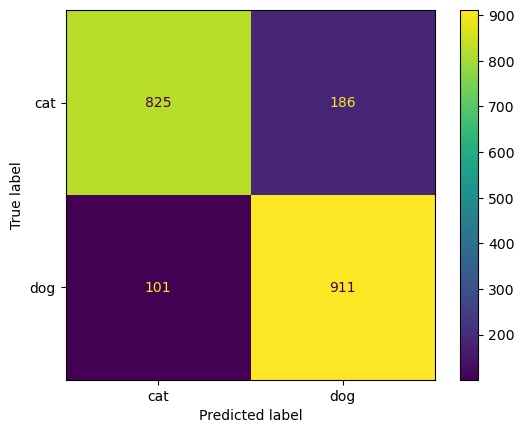

In [40]:
cfmt = confusion_matrix(y_true, y_pred )
disp = ConfusionMatrixDisplay(cfmt, display_labels=['cat', 'dog'])
disp.plot()

In [41]:
!zip -r '/kaggle/working/classifier.zip' '/kaggle/working/classifier'

  adding: kaggle/working/classifier/ (stored 0%)
  adding: kaggle/working/classifier/keras_metadata.pb (deflated 93%)
  adding: kaggle/working/classifier/assets/ (stored 0%)
  adding: kaggle/working/classifier/fingerprint.pb (stored 0%)
  adding: kaggle/working/classifier/saved_model.pb (deflated 89%)
  adding: kaggle/working/classifier/variables/ (stored 0%)
  adding: kaggle/working/classifier/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: kaggle/working/classifier/variables/variables.index (deflated 67%)
